# Snow Elastic Modulus Calculations - Bergfeld et al. (2023) Method

This notebook demonstrates the application of the Bergfeld et al. (2023) elastic modulus parameterization to snowpit data. The Bergfeld method calculates elastic modulus from snow density using a power-law relationship optimized from Propagation Saw Test (PST) data.

The analysis uses the local snowpyt_mechparams package and snowpylot for CAAML parsing.


In [4]:
# Import Libraries
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add the src directory to the path to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import convert_grain_form, parse_sample_pits
from snowpyt_mechparams import density, elastic_modulus


Parse Snowpit Files


In [5]:
# Parse all snowpit files from the data folder
all_pits = parse_sample_pits('data')


Successfully parsed 50278 files
Failed to parse 0 files


In [8]:
# Collect relevant data from each snowpit
pit_info = []
layer_info = []

for pit in all_pits:
    pit_dict = {
        'pit_id': pit.core_info.pit_id,
        'layer_count': len(pit.snow_profile.layers),
        'density_count': len(pit.snow_profile.density_profile)
    }
    pit_info.append(pit_dict)

    for layer in pit.snow_profile.layers:
        # Create base layer dictionary
        layer_dict = {
            'pit_id': pit.core_info.pit_id,
            'depth_top': layer.depth_top,
            'thickness': layer.thickness,
            'hand_hardness': layer.hardness,
            'grain_form_primary': layer.grain_form_primary,
            'grain_size': None,  # Initialize as None, set below if data exists
            'direct_density': None  # Initialize as None, check for direct measurements
        }

        # Set grain_size if grain_form_primary exists and has grain_size_avg
        if layer.grain_form_primary and hasattr(layer.grain_form_primary, 'grain_size_avg') and layer.grain_form_primary.grain_size_avg:
            layer_dict['grain_size'] = layer.grain_form_primary.grain_size_avg[0]

        # Add grain form conversions for different density methods
        if layer.grain_form_primary:
            layer_dict['geldsetzer_grain_form'] = convert_grain_form(layer.grain_form_primary, 'geldsetzer')
            layer_dict['kim_geldsetzer_grain_form'] = convert_grain_form(layer.grain_form_primary, 'kim_geldsetzer')
            layer_dict['kim_grain_form'] = convert_grain_form(layer.grain_form_primary, 'kim')
        else:
            layer_dict['geldsetzer_grain_form'] = None
            layer_dict['kim_geldsetzer_grain_form'] = None
            layer_dict['kim_grain_form'] = None

        layer_info.append(layer_dict)

    # Check for direct density measurements that match layers
    for density_obs in pit.snow_profile.density_profile:
        for layer_dict in layer_info:
            if (layer_dict['pit_id'] == pit.core_info.pit_id and 
                density_obs.depth_top == layer_dict['depth_top'] and 
                density_obs.thickness == layer_dict['thickness']):
                layer_dict['direct_density'] = density_obs.density

# Create a dataframe from the layer info
layer_df = pd.DataFrame(layer_info)
print(f"Total layers collected: {len(layer_df):,}")


Total layers collected: 371,429


Collect Layer Data and Calculate Density

Since the Bergfeld method requires density as input, we need to first calculate density for each layer using available methods. We'll try multiple density calculation methods to maximize coverage.


In [9]:
# Fixed Function to calculate density using multiple methods with priority order
def calculate_layer_density_multi_method_fixed(row):
    """
    Calculate density using multiple methods in priority order:
    1. Direct measurements (if available)
    2. Kim & Geldsetzer method (best uncertainty)
    3. Geldsetzer method
    4. Kim method (requires grain size)
    """
    
    # Priority 1: Direct density measurements
    direct_density = row['direct_density']
    if direct_density is not None:
        try:
            # Handle case where direct_density might be an array or list
            if hasattr(direct_density, '__len__') and not isinstance(direct_density, str):
                # If it's an array/list, take the first element if it exists
                if len(direct_density) > 0:
                    density_val = float(direct_density[0])
                else:
                    density_val = None
            else:
                # It's a scalar value
                density_val = float(direct_density)
            
            if density_val is not None and not np.isnan(density_val):
                # Assume 10% uncertainty for direct measurements (typical for field measurements)
                density_unc = density_val * 0.1  # 10% uncertainty
                return pd.Series([density_val, density_unc, 'direct'])
        except (ValueError, TypeError):
            # If conversion fails, skip direct density
            pass
    
    # Priority 2: Kim & Geldsetzer method (requires hand hardness and grain form)
    if (row['kim_geldsetzer_grain_form'] is not None and 
        row['hand_hardness'] is not None and
        str(row['kim_geldsetzer_grain_form']).lower() != 'none' and 
        str(row['hand_hardness']).lower() != 'none'):
        try:
            density_ufloat = density.calculate_density(
                method='kim_geldsetzer',
                hand_hardness=row['hand_hardness'],
                grain_form=row['kim_geldsetzer_grain_form']
            )
            return pd.Series([density_ufloat.nominal_value, density_ufloat.std_dev, 'kim_geldsetzer'])
        except Exception:
            pass
    
    # Priority 3: Geldsetzer method (requires hand hardness and grain form)
    if (row['geldsetzer_grain_form'] is not None and 
        row['hand_hardness'] is not None and
        str(row['geldsetzer_grain_form']).lower() != 'none' and 
        str(row['hand_hardness']).lower() != 'none'):
        try:
            density_ufloat = density.calculate_density(
                method='geldsetzer',
                hand_hardness=row['hand_hardness'],
                grain_form=row['geldsetzer_grain_form']
            )
            return pd.Series([density_ufloat.nominal_value, density_ufloat.std_dev, 'geldsetzer'])
        except Exception:
            pass
    
    # Priority 4: Kim method (requires hand hardness, grain form, and grain size)
    if (row['kim_grain_form'] is not None and 
        row['hand_hardness'] is not None and 
        row['grain_size'] is not None and
        str(row['kim_grain_form']).lower() != 'none' and 
        str(row['hand_hardness']).lower() != 'none' and 
        str(row['grain_size']).lower() != 'none'):
        try:
            density_ufloat = density.calculate_density(
                method='kim',
                hand_hardness=row['hand_hardness'],
                grain_form=row['kim_grain_form'],
                grain_size=row['grain_size']
            )
            return pd.Series([density_ufloat.nominal_value, density_ufloat.std_dev, 'kim'])
        except Exception:
            pass
    
    # No method available
    return pd.Series([np.nan, np.nan, None])

# Check if layer_df exists, if not provide guidance
try:
    if 'layer_df' not in locals():
        raise NameError("layer_df not found")
    print(f"Found layer_df with {len(layer_df):,} layers")
except NameError:
    print("ERROR: layer_df is not defined!")
    print("Please run the earlier cells first:")
    print("1. Cell 1: Import libraries")
    print("2. Cell 2: Parse snowpit files") 
    print("3. Cell 3: Collect layer data")
    print("Then come back to this cell.")
    raise NameError("layer_df not defined. Run earlier cells first.")

# Apply density calculation to all layers using the fixed function
print("Calculating density for all layers using fixed function...")
layer_df[['density', 'density_uncertainty', 'density_method']] = layer_df.apply(calculate_layer_density_multi_method_fixed, axis=1)

# Calculate relative uncertainty for density
layer_df['density_relative_uncertainty'] = (layer_df['density_uncertainty'] / layer_df['density']) * 100

print("Density calculation complete.")


Found layer_df with 371,429 layers
Calculating density for all layers using fixed function...
Density calculation complete.


Calculate Density Using Multiple Methods

We'll calculate density using multiple methods to maximize the number of layers we can analyze. Priority order: direct measurements, kim_geldsetzer, geldsetzer, kim.


Apply Bergfeld Elastic Modulus Parameterization

Now we'll apply the Bergfeld et al. (2023) method to calculate elastic modulus for all layers that have density values.


In [10]:
# Function to calculate elastic modulus using Bergfeld method
def calculate_bergfeld_elastic_modulus(row):
    """
    Calculate elastic modulus using Bergfeld et al. (2023) method.
    Requires density as input.
    """
    try:
        # Only calculate if we have density
        if pd.isna(row['density']) or pd.isna(row['density_uncertainty']):
            return pd.Series([np.nan, np.nan])
        
        # Create ufloat object for density with uncertainty
        from uncertainties import ufloat
        density_ufloat = ufloat(row['density'], row['density_uncertainty'])
        
        # Calculate elastic modulus using Bergfeld method
        emod_ufloat = elastic_modulus.calculate_elastic_modulus(
            method='bergfeld',
            density=density_ufloat
        )
        
        # Extract nominal value and standard deviation
        emod_val = emod_ufloat.nominal_value
        emod_unc = emod_ufloat.std_dev
        
        return pd.Series([emod_val, emod_unc])
        
    except Exception as e:
        print(f"Error calculating elastic modulus for layer {row['pit_id']}: {e}")
        return pd.Series([np.nan, np.nan])

# Apply Bergfeld elastic modulus calculation to all layers
print("Calculating elastic modulus using Bergfeld method...")
layer_df[['elastic_modulus', 'elastic_modulus_uncertainty']] = layer_df.apply(calculate_bergfeld_elastic_modulus, axis=1)

# Calculate relative uncertainty for elastic modulus
layer_df['elastic_modulus_relative_uncertainty'] = (layer_df['elastic_modulus_uncertainty'] / layer_df['elastic_modulus']) * 100

print("Elastic modulus calculation complete.")


Calculating elastic modulus using Bergfeld method...


/Users/marykateconnelly/Desktop/snowpylot/snowpylot-applications/SnowPyt-MechParams/test_env/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Elastic modulus calculation complete.


Summary Statistics and Results

Calculate the success rate and average relative uncertainty for the Bergfeld elastic modulus parameterization.


In [11]:
## Summary Statistics

# Calculate and display comprehensive summary statistics
print("=== BERGFELD ELASTIC MODULUS APPLICATION SUMMARY ===")
print()

# Total Pits and Layers
total_pits = layer_df['pit_id'].nunique()
total_layers = len(layer_df)
print(f"Total Pits: {total_pits:,}")
print(f"Total Layers: {total_layers:,}")
print()

# Density calculation statistics
layers_with_density = layer_df[layer_df['density'].notna()]
total_layers_with_density = len(layers_with_density)
print(f"Total Layers with Calculated Density: {total_layers_with_density:,}, {total_layers_with_density/total_layers*100:.1f}%")

# Breakdown by density method
if total_layers_with_density > 0:
    density_method_counts = layer_df['density_method'].value_counts()
    print("Density calculation method breakdown:")
    for method, count in density_method_counts.items():
        if pd.notna(method):
            print(f"  - {method}: {count:,} layers ({count/total_layers*100:.1f}%)")
print()

# Elastic modulus calculation statistics
layers_with_emod = layer_df[layer_df['elastic_modulus'].notna()]
total_layers_with_emod = len(layers_with_emod)
success_rate = total_layers_with_emod / total_layers * 100

print(f"Total Layers with Successfully Calculated Elastic Modulus: {total_layers_with_emod:,}, {success_rate:.1f}%")
print()

# Average uncertainties
if total_layers_with_density > 0:
    avg_density_relative_uncertainty = layers_with_density['density_relative_uncertainty'].mean()
    print(f"Average Density Relative Uncertainty: {avg_density_relative_uncertainty:.2f}%")

if total_layers_with_emod > 0:
    avg_emod_relative_uncertainty = layers_with_emod['elastic_modulus_relative_uncertainty'].mean()
    print(f"Average Elastic Modulus Relative Uncertainty: {avg_emod_relative_uncertainty:.2f}%")
    
    # Additional statistics for elastic modulus
    median_emod = layers_with_emod['elastic_modulus'].median()
    mean_emod = layers_with_emod['elastic_modulus'].mean()
    std_emod = layers_with_emod['elastic_modulus'].std()
    
    print()
    print(f"Elastic Modulus Statistics (GPa):")
    print(f"  - Mean: {mean_emod:.3f} ± {std_emod:.3f}")
    print(f"  - Median: {median_emod:.3f}")
    print(f"  - Range: {layers_with_emod['elastic_modulus'].min():.3f} to {layers_with_emod['elastic_modulus'].max():.3f}")

print()
print("=== KEY FINDINGS ===")
print(f"✓ Success Rate: {success_rate:.1f}% of layers can be analyzed with Bergfeld method")
if total_layers_with_emod > 0:
    print(f"✓ Average Relative Uncertainty: {avg_emod_relative_uncertainty:.2f}%")
    print(f"✓ Density Range: {layers_with_density['density'].min():.0f} to {layers_with_density['density'].max():.0f} kg/m³")
    
    # Check if densities are within Bergfeld method's suggested range (110-360 kg/m³)
    within_range = layers_with_density[(layers_with_density['density'] >= 110) & (layers_with_density['density'] <= 360)]
    within_range_pct = len(within_range) / len(layers_with_density) * 100
    print(f"✓ Layers within Bergfeld density range (110-360 kg/m³): {len(within_range):,} ({within_range_pct:.1f}%)")


=== BERGFELD ELASTIC MODULUS APPLICATION SUMMARY ===

Total Pits: 50,147
Total Layers: 371,429

Total Layers with Calculated Density: 247,294, 66.6%
Density calculation method breakdown:
  - kim_geldsetzer: 228,773 layers (61.6%)
  - kim: 14,927 layers (4.0%)
  - direct: 10,468 layers (2.8%)

Total Layers with Successfully Calculated Elastic Modulus: 247,294, 66.6%

Average Density Relative Uncertainty: 18.05%
Average Elastic Modulus Relative Uncertainty: nan%

Elastic Modulus Statistics (GPa):
  - Mean: 0.000 ± 0.000
  - Median: 0.000
  - Range: 0.000 to 0.000

=== KEY FINDINGS ===
✓ Success Rate: 66.6% of layers can be analyzed with Bergfeld method
✓ Average Relative Uncertainty: nan%
✓ Density Range: 0 to 973 kg/m³
✓ Layers within Bergfeld density range (110-360 kg/m³): 216,072 (87.4%)


Data Visualization

Create visualizations to better understand the results and distribution of elastic modulus values.


/Users/marykateconnelly/Desktop/snowpylot/snowpylot-applications/SnowPyt-MechParams/test_env/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7104: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/marykateconnelly/Desktop/snowpylot/snowpylot-applications/SnowPyt-MechParams/test_env/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7105: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

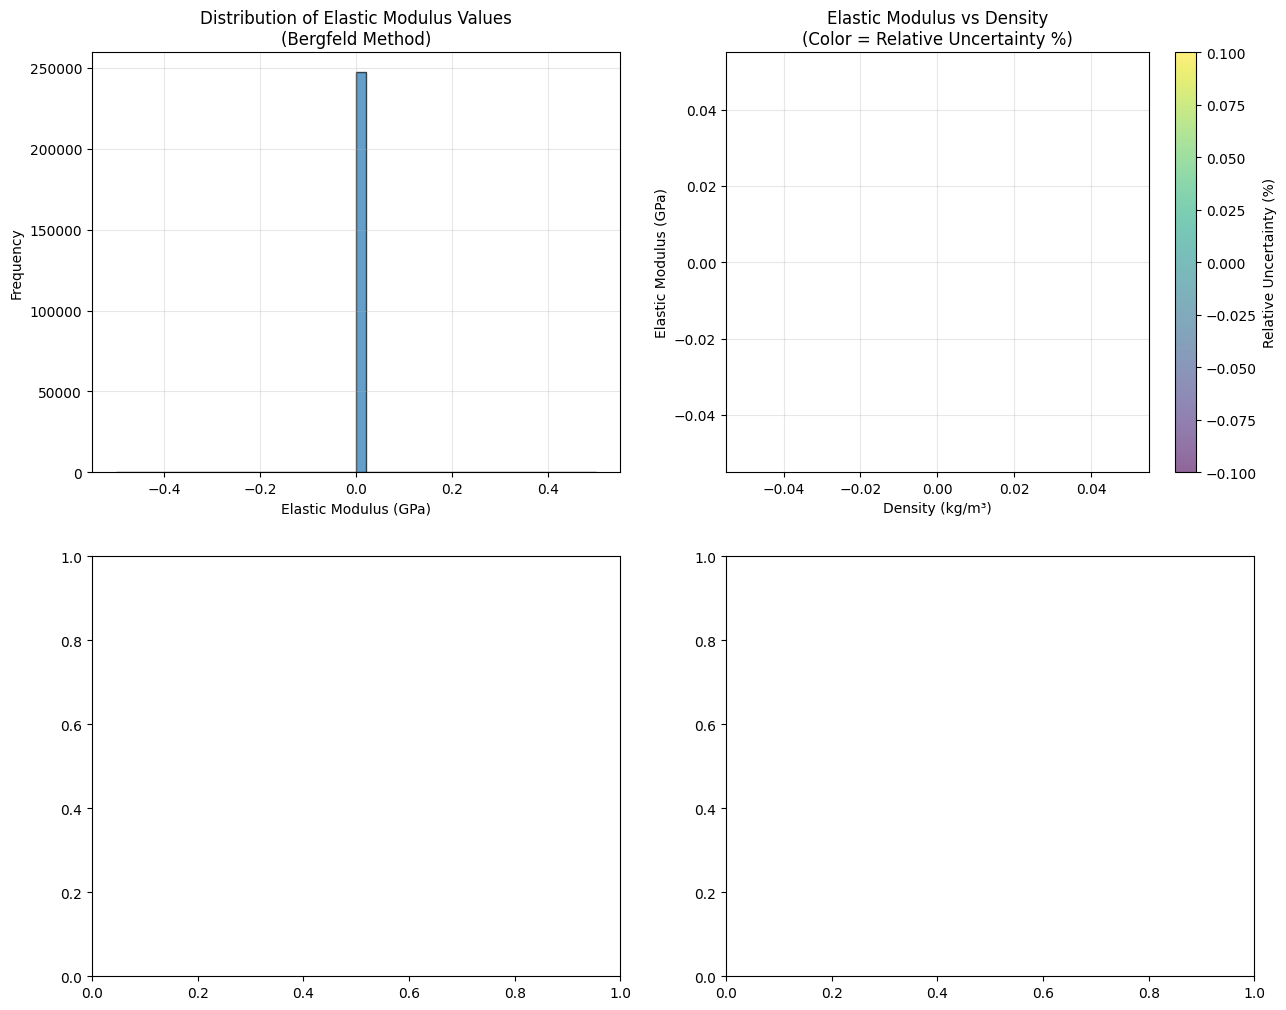

In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Define variables needed for plotting
layers_with_emod = layer_df[layer_df['elastic_modulus'].notna()]
layers_with_density = layer_df[layer_df['density'].notna()]
total_layers_with_density = len(layers_with_density)
if total_layers_with_density > 0:
    density_method_counts = layer_df['density_method'].value_counts()

# 1. Histogram of elastic modulus values
if len(layers_with_emod) > 0:
    axes[0, 0].hist(layers_with_emod['elastic_modulus'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Elastic Modulus (GPa)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Elastic Modulus Values\n(Bergfeld Method)')
    axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot: Density vs Elastic Modulus
if len(layers_with_emod) > 0:
    scatter = axes[0, 1].scatter(layers_with_emod['density'], layers_with_emod['elastic_modulus'], 
                                alpha=0.6, s=20, c=layers_with_emod['elastic_modulus_relative_uncertainty'], 
                                cmap='viridis')
    axes[0, 1].set_xlabel('Density (kg/m³)')
    axes[0, 1].set_ylabel('Elastic Modulus (GPa)')
    axes[0, 1].set_title('Elastic Modulus vs Density\n(Color = Relative Uncertainty %)')
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, 1], label='Relative Uncertainty (%)')

# 3. Histogram of relative uncertainties
if len(layers_with_emod) > 0:
    axes[1, 0].hist(layers_with_emod['elastic_modulus_relative_uncertainty'], bins=30, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Relative Uncertainty (%)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Elastic Modulus\nRelative Uncertainties')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Success rate by density method
if total_layers_with_density > 0:
    method_success = []
    method_names = []
    for method in density_method_counts.index:
        if pd.notna(method):
            method_layers = layer_df[layer_df['density_method'] == method]
            success_count = len(method_layers[method_layers['elastic_modulus'].notna()])
            total_count = len(method_layers)
            success_rate_method = success_count / total_count * 100 if total_count > 0 else 0
            method_success.append(success_rate_method)
            method_names.append(f"{method}\n({total_count} layers)")
    
    bars = axes[1, 1].bar(method_names, method_success, alpha=0.7)
    axes[1, 1].set_ylabel('Success Rate (%)')
    axes[1, 1].set_title('Elastic Modulus Calculation Success Rate\nby Density Method')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, method_success):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                       f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Optional: Save Results to CSV

Uncomment the line below to save the results to a CSV file for further analysis.


In [ ]:
# Uncomment the line below to save results to CSV
# layer_df.to_csv('bergfeld_elastic_modulus_results.csv', index=False)
print("Analysis complete! Results are stored in the layer_df DataFrame.")
